## Precinct voters maps

My goal was to analyze the voters in a precinct: specifically, what addresses don't have recorded votes.

I downloaded some data from the [Durham ArcGIS server](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer).

Here is an example of the fields that each record has: [record 1](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer/89/1)

Note: I use the form `test -f file || get file` to prevent re-running commands. You can delete the files to redownload.

In [1]:
PRECINCT = '01'
%env PRECINCT=$PRECINCT

env: PRECINCT=01


In [2]:
!test -f Precincts.shp || ( wget https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20161004.zip && unzip SBE_PRECINCTS_20161004.zip )

In [3]:
!test -f precinct-$PRECINCT.shp || ogr2ogr -sql "select * from Precincts where COUNTY_NAM='DURHAM' and PREC_ID='$PRECINCT'" -t_srs EPSG:4326 precinct-$PRECINCT.shp Precincts.shp

In [4]:
!ogr2ogr -f geojson precinct-$PRECINCT.geojson precinct-$PRECINCT.shp

ERROR 6: The GeoJSON driver does not overwrite existing files.
geojson driver failed to create precinct-01.geojson


I used paw to mess with the HTTP params, but generally I just added the `"RES` filter above to my curl request. Note that ArcGIS does not create geojson out of the box. I used the ogr2ogr tool to convert it ([thanks SO](http://gis.stackexchange.com/questions/13029/converting-arcgis-server-json-to-geojson)).

But what I really want is everything within the precinct area, so I need to make an intersection with the precinct boundary to filter out non-precinct properties.

The Durham GIS server has a limit to how many records you can download in one request. To avoid this exceededTransferLimit error, I batch the requests in chunks.

In [5]:
# load local library made just for arcgis wrangling:
from arcgis import downloader
import geopandas as gpd
import os

precinct = gpd.GeoDataFrame.from_file("precinct-{}.shp".format(PRECINCT))
bounds = precinct.bounds

all_lots_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
all_lots_url = all_lots_url_template.format(bounds['minx'][0], bounds['miny'][0], bounds['maxx'][0], bounds['maxy'][0])

ALL_LOTS='all_lots-{}'.format(PRECINCT)
ALL_LOTS_SHP='{}.shp'.format(ALL_LOTS)
lots = None
if not os.path.exists(ALL_LOTS_SHP):
    lots = downloader.download_shp(all_lots_url, ALL_LOTS)
else:
    lots = gpd.GeoDataFrame.from_file(ALL_LOTS_SHP)
    
streets_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/54/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
streets_url = streets_url_template.format(bounds['minx'][0], bounds['miny'][0], bounds['maxx'][0], bounds['maxy'][0])
streets = None
if not os.path.exists('streets-{}.shp'.format(PRECINCT)):
    streets = downloader.download_shp(streets_url, 'streets-{}'.format(PRECINCT))
else:
    streets = gpd.GeoDataFrame.from_file('streets-{}.shp'.format(PRECINCT))

In [6]:
print('Properties from arcgis boundary: {}'.format(len(lots)))

precinct = precinct.to_crs({'init': 'epsg:4326'})

lots_in_precinct = gpd.sjoin(lots, precinct, op='within')

print('Properties in precinct {}: {}'.format(PRECINCT, len(lots_in_precinct)))

lots_in_precinct.to_file('precinct-{}-lots.shp'.format(PRECINCT))

Properties from arcgis boundary: 1304
Properties in precinct 01: 606


In [7]:
!rm -f precinct-$PRECINCT-lots.geojson && ogr2ogr -f geojson precinct-$PRECINCT-lots.geojson precinct-$PRECINCT-lots.shp

## Addresses in Princinct 21

In [8]:
import folium

map = folium.Map(location=[36.025, -78.899], tiles='CartoDB positron', zoom_start=15)
map.choropleth(geo_path='precinct-{}-lots.geojson'.format(PRECINCT))
map.choropleth(geo_path='precinct-{}.geojson'.format(PRECINCT), fill_opacity=0.2, line_opacity=0)
map

In [9]:
import pandas as pd

voters = pd.read_csv('ncvoter32.txt', sep=None)

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [10]:
voters_in_precinct = voters[voters.county_desc=="DURHAM"]
voters_in_precinct = voters_in_precinct[voters_in_precinct.precinct_desc==PRECINCT]

In [11]:
# voters_in_precinct.dtypes
# pd.value_counts()
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

While messing around with this data, I did notice a strict "only RES" top level category properties left some gaps in neighborhoods, which didn't seem right. I settled on a looser "anything with RES" in the category description.

From the map below you can see we get a couple weird extras that maybe ought to be filtered out: "VAC RES", "CONVERTED RESIDENCE".

RES                         522
COM                          33
VAC RES                      25
CMNTY SVC                    10
VACANT COMMERCIAL             8
VACANT PUBLIC UTILITY         3
VACANT COMMUNITY SERVICE      2
VAC COM                       1
CMNTY SVS                     1
PUBL SVC                      1
Name: LANDUSE_CODE, dtype: int64

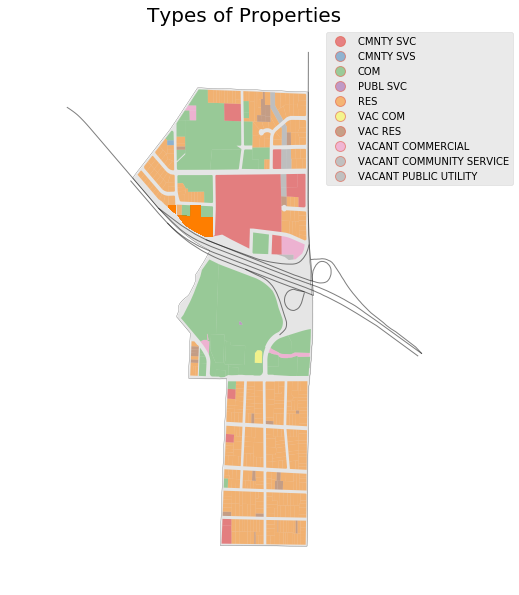

In [57]:
import geopandas as gpd

all_lots_pd = gpd.read_file('precinct-{}-lots.shp'.format(PRECINCT))
precinct_boundary_pd = gpd.read_file('precinct-{}.shp'.format(PRECINCT))

all_lots_pd['LANDUSE_CODE'] = all_lots_pd['LANDUSE_DE'].str.replace(r'/.*$','')


fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)

all_lots_pd.plot(ax=ax, column='LANDUSE_CODE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.2, 0.0))
plt.title('Types of Properties', fontsize=20)

all_lots_pd['LANDUSE_CODE'].value_counts()

## Properties with no voters

Finally, joining the ArcGIS data to the we get a sense of what areas could use some voter outreach.

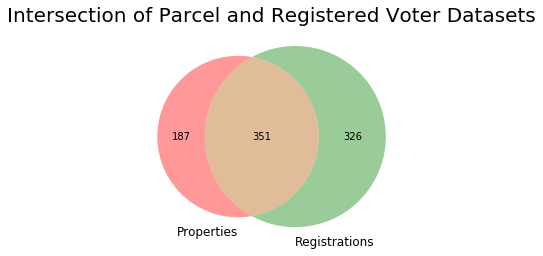

In [13]:
# so now that I have a shapefile of residential addresses, lets make files of addresses
# with no voters:

# remove apartment numbers from addresses, to match up more addresses.
# TODO it might be possible to determine how many addresses have multiple tenants and use this apartment
# number to determine which apartments have no registered addresses:
apartments = voters_in_precinct['mail_addr1'].str.contains(' # ').fillna(False)
voters_in_precinct['mail_addr1'][apartments] = voters_in_precinct['mail_addr1'][apartments].str.replace(r' # .*$','')
apartments = voters_in_precinct['mail_addr1'].str.contains(' # ').fillna(False)
assert(len(voters_in_precinct[apartments]) == 0)

matched_regs = all_lots_pd.query('SITE_ADDRE in @voters_in_precinct.mail_addr1')
non_matched_props = all_lots_pd.query('SITE_ADDRE not in @voters_in_precinct.mail_addr1')
non_matched_regs = voters_in_precinct.query('mail_addr1 not in @all_lots_pd.SITE_ADDRE')

# filter out properties that are definitely NOT residential:
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('COM') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('WILD') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('CMNTY SVC') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('PUBL SVC') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('VACANT') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('VAC RES') != True]
non_matched_props = non_matched_props[non_matched_props.LANDUSE_DE.str.startswith('REC/ SOCIAL ORGANIZATIONS') != True]

# all_lots_pd[['SITE_ADDRE','LANDUSE_DE']][all_lots_pd['SITE_ADDRE'].str.contains('23 N ROXBORO')]

# lots[['SITE_ADDRE','LANDUSE_DE']][lots['SITE_ADDRE'].str.contains('3523')]

# lots[['SITE_ADDRE','LANDUSE_DE']][lots.LANDUSE_DE == 'COM/ APARTMENT-GARDEN']

# top ten addresses with registered voters (but couldn't find them on the map):
# non_matched_regs['mail_addr1'].value_counts()[:10]

from matplotlib_venn import venn2
venn2(subsets = (len(non_matched_props), len(non_matched_regs), len(matched_regs)), set_labels=('Properties', 'Registrations'))
plt.title('Intersection of Parcel and Registered Voter Datasets', fontsize=20)

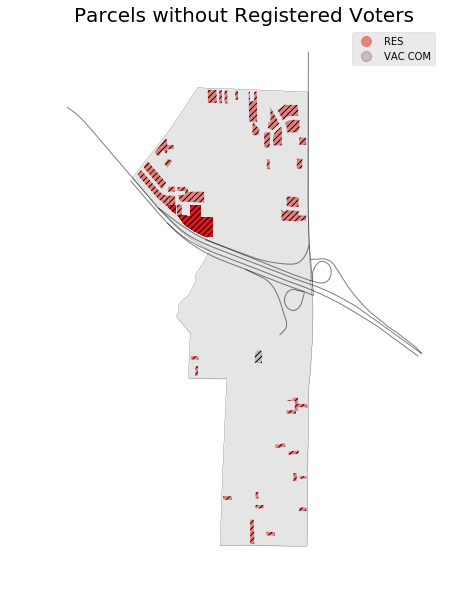

In [54]:
fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
non_matched_props.plot(ax=ax, column='LANDUSE_CODE', edgecolor='none', legend=True, hatch='////')
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.0, 0.0))
plt.title('Parcels without Registered Voters', fontsize=20)

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/geopandas/plotting.py:414: SyntaxWarning: Only specify one of 'column' or 'color'. Using 'color'.
  SyntaxWarning)


Voter breakdown:


DEM    671
UNA    296
REP     71
LIB      9
Name: party_cd, dtype: int64

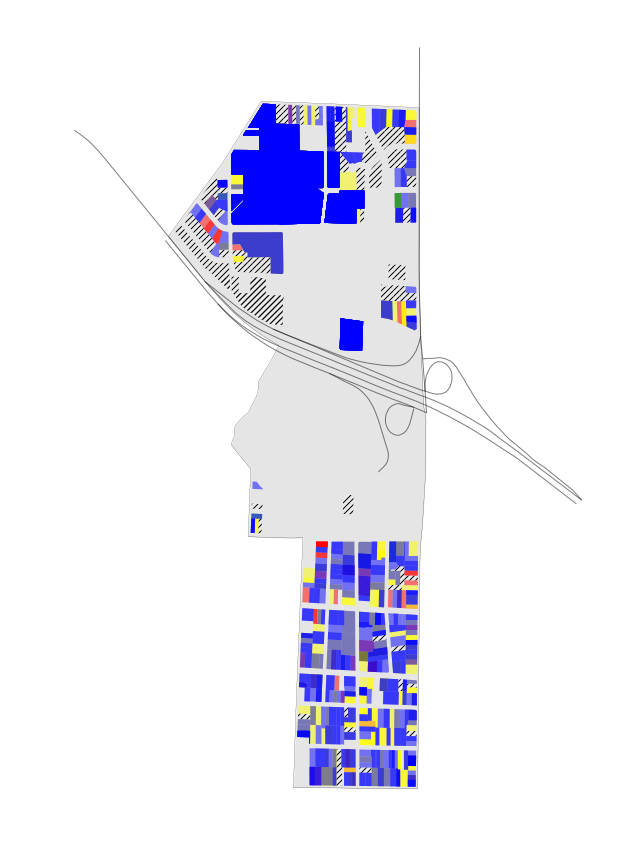

In [52]:
# and by party. Note that some places are super blue/red (all blue/red voters in the house).
# Purple for mixed houses, etc.

voters_pd = all_lots_pd.merge(voters_in_precinct,left_on='SITE_ADDRE',right_on='mail_addr1')

colors = {
    'DEM': 'blue',
    'LIB': 'green',
    'REP': 'red',
    'UNA': 'yellow'
}

fig, ax = plt.subplots(1, figsize=(10,15))
ax.axis('off')

# plot the boundary file and the properties without voters:
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
non_matched_props.plot(ax=ax, color='#eeeeee', edgecolor='none', hatch='////')

# then plot each voter:
for k,v in colors.items():
    voters_pd[voters_pd.party_cd==k].plot(
        ax=ax, column='party_cd', linewidth=0, alpha=0.5, color=v
    )

print("Voter breakdown:")
voters_pd['party_cd'].value_counts()

In [16]:
# Given the average number of voters in any given house of registered voters, we could
# predict that each address with no voters registered NOW, might yield that average if
# one knocked on their door:

voters_per_address = voters_pd.groupby('mail_addr1')
avg_voters_per_address = voters_per_address.size().describe()['mean']

untapped = int(avg_voters_per_address * len(non_matched_props))
dems = voters_pd['party_cd'].value_counts()['DEM']
percent_dems = dems / len(voters_pd)

print('Average voters at an address WITH voters: {:.1f}'.format(avg_voters_per_address))
print('Total addresses w/o voters:{}'.format(len(non_matched_props)))
print('Potential untapped voters: {}'.format(untapped))
print('Potential untapped Dems:   {}'.format(int(untapped * percent_dems)))

Average voters at an address WITH voters: 3.0
Total addresses w/o voters:187
Potential untapped voters: 561
Potential untapped Dems:   359
